# Math

Wavenumber which maximizes growth rate:
\begin{align*}
    \kappa = 2\frac{f_0}{N_0H}
\end{align*}

Parameters:
\begin{align*}
     f_0 &= 2\Omega = 2\frac{R}{2000}=\frac{R}{1000}~\text{rad/s}\\
     N_0^2 &= \frac{2g}{\Delta z}\left[\frac{\alpha\Delta T}{2+\alpha\Delta T}\right]~\text{s}^{-2}\\
     H   &= 0.133~\text{m}\\
     L_d &= \frac{N_0H}{f_0}
\end{align*}

Compute $\kappa$:
\begin{align*}
    \kappa &= \frac{2}{L_d}~\text{rad/m}
\end{align*}
Max instability occurs for gravest meridional wavenumber. Distance across channel is $\approx.14$ m. A full cycle in the channel corresponds to a wavenumber of $\frac{1}{0.14}$ cycles/m; for the gravest mode, we have a half-cycle in the channel, corresponding to $\frac{0.5}{0.14}$ cycles/m, or $l\approx 22.4$ radians/m. $\kappa^2=k^2+l^2$, so zonal wavenumber is $k=\sqrt{\kappa^2-l^2}=\sqrt{\left(\frac{2}{L_d}\right)^2-22.4^2}$ radians/meter. Next, convert from radians/meter to cycles/circumference (planetary wavenumber). The circumference of channel (at midpoint between can and outer edge) is $\approx 1.0$ m.

\begin{align*}
    k_{planetary} &= k~\text{rad/m} \times \frac{1}{2\pi}~\text{cycles/rad} \times 2\pi r\
    \text{m}\\
    &= kr~\text{cycles/circumference}
\end{align*}

## Derivation of $N^2$

Denote $\rho_1$ and $\rho_2$ denote densities at upper and lower sensors, respectively. Begin with definition of $N^2$:
\begin{align*}
    N^2 &= -\frac{g}{\tilde{\rho}}\left(\frac{\partial \tilde{\rho}}{\partial z}\right)\\
        &\approx -\frac{2g}{\rho_1+\rho_2}\left(\frac{\rho_1-\rho_2}{\Delta z}\right)\\
        &= \frac{2g}{\rho_1+\rho_2}\left(\frac{\rho_2-\rho_1}{\Delta z}\right)
\end{align*}

Approximate density as:
\begin{align*}
    \rho &\approx \rho_0\left[1-\alpha\left(T-T_0\right)\right]\\
\end{align*}
Use upper-level density as reference (i.e. set $\rho_0=\rho_1$):
\begin{align*}
    \rho_2 &\approx \rho_1\left[1-\alpha\left(T_2-T_1\right)\right]\\
    &= \rho_1\left[1+\alpha\Delta T\right]
\end{align*}
Compute difference and sum between densities:
\begin{align*}
    \implies \rho_2-\rho_1 &\approx \rho_1\left[1+\alpha\Delta T\right] - \rho_1\\
    &= \rho_1\alpha\Delta T\\
    \rho_2+\rho_1 &= \rho_1\left[1+\alpha\Delta T\right] + \rho_1\\
    &= \rho_1\left[2+\alpha\Delta T\right]
\end{align*}

Substitute:
\begin{align*}
    N^2 &= \frac{2g}{\rho_1\left[2+\alpha\Delta T\right]}\left(\frac{\rho_1\alpha\Delta T}{\Delta z}\right)\\
    &= \frac{2g}{\Delta z}\left[\frac{\alpha\Delta T}{2+\alpha\Delta T}\right]\\
    &\approx \alpha g\frac{\Delta T}{\Delta z}
\end{align*}

## Zonal wavenumber cutoff

\begin{align*}
    k&=\sqrt{\kappa^2-l^2}=\sqrt{\left(\frac{2}{L_d}\right)^2-l^2}\\
    &=\sqrt{\kappa^2-l^2}=\sqrt{\left(\frac{2f_0}{N_0H}\right)^2-l^2}
\end{align*}
Inside of square root is positive if:
\begin{align*}
    \left(\frac{2f_0}{N_0H}\right)^2 &>l^2\\
    \frac{2f_0}{N_0H} &>l\\
    f_0&>l\frac{N_0H}{2}\\
    &\approx (22.4)\frac{(0.27)(0.13)}{2}\\
    &= 0.39
\end{align*}

#### Compute zonal wavenumber cutoff

In [11]:
print(22.4*.27*.13/2)

0.39312


# Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import gsw
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 75

In [2]:
def get_N0(T,p):
    '''Compute buoyancy frequency given Temperature at two depths, using custom function. 
    First col of {T,p} is {T,p} at upper sensor'''
    a  = 2e-4 # K^{-1}
    g  = 9.8  # m/s^2
    dT = T[:,0]-T[:,1] # upper temperature minus lower temperature
    dz = np.tile(p[:,1]-p[:,0], (dT.shape[0])) # lower pressure minus upper pressure
    N2 = a*g*dT/dz 
    return np.sqrt(N2)[:,None]

def get_f0(R):
    '''Compute f0 based on "R" value
    factor of 2pi?'''
    Omega = R/2000
    return 2*Omega

def get_Ld(T,p,R,H):
    '''Compute deformation radius'''
    N  = get_N0(T,p)
    f0 = get_f0(R)
    return N*H/f0

def get_kappa(Ld, radius, use_l, channel_width):
    '''Compute max wavenumber based on deformation radius (Ld) and distance from center (radius).
    Distance from center matters because this value is the number of waves which "fit" in the domain'''
    kappa_rad_m = 2/Ld                    # units of radians/m
    if use_l:
        l = np.pi / channel_width # gravest meridional wavenumber, in radians/meter
    else:
        l = 0
    k_rad_m     = np.sqrt(kappa_rad_m**2 - l**2)
    k_planetary = k_rad_m * radius
    return k_planetary

def compute_kappa(r, use_l=False):
    ## Compute number of waves which fit in domain
    X     = T_data[r]
    kappas= []
    Lds   = [] # deformation radii
    for j in range(4):
        i  = 2*(j+1)                    # index for upper sensor column
        T     = X.iloc[:,i:i+2].values  # temp. at upper/lower sensor
        p     = sensor_depth[j:j+1]     # get pressure at sensor locations
        Ld    = get_Ld(T,p,r,H)
        kappa = get_kappa(Ld, radii[j], use_l=use_l, channel_width=radii[-1]-radii[0])
        kappas.append(kappa)
        Lds.append(Ld)
    return np.concatenate(kappas, axis=1), np.concatenate(Lds, axis=1)

# Dimensions and load data

In [3]:
##### dimensions of domain ####
cm_per_in  = 2.54
r_can_in   = 3.5
r_inner_in = 9
H_in       = 5.25
r_can, r_inner, H = [i*cm_per_in/100 for i in [r_can_in, r_inner_in, H_in]]
radii = np.array([r_can, (r_can*3+r_inner)/4, (r_can+r_inner)/2, r_inner])

#### Sensor depths #####
sensor_hgt_in = np.array([[1.0 , 4.25], # inches
                          [2.0 , 5.0],
                          [1.5 , 4.5],
                          [0.75, 3.5]])
sensor_hgt_in = sensor_hgt_in[:,::-1] # reverse order so that height of upper sensor is in left column
sensor_depth  = (H_in-sensor_hgt_in) * cm_per_in / 100 # m

##### Load data #####
T_data = pd.ExcelFile('data.xlsx')
T_data = pd.read_excel(T_data, sheet_name=None)
old_keys = list(T_data)
R_vals   = [2000,500,300,100]
T_data   = {k_new : T_data[k_old] for k_new, k_old in zip(R_vals, old_keys)}
time_s   = T_data[100].iloc[:,0].values
time_min = time_s/60

## Compute mean temperatures

In [4]:
cutoff  = 300
plot    = False
colors  = sns.color_palette()
T_means = []
for ri, r in enumerate(R_vals):
    T_means_r = []
    for si in range(4):
        T = T_data[r].iloc[:,[2*(si+1),2*(si+1)+1]].values
        if r>300:
            cutoff_idx = np.where(time_s==300)[0].item()
            T_mean = T[cutoff_idx:].mean(0)
        else:
            T_mean = T.mean(0)
        T_means_r.append(T_mean)             
            
        if plot:
            fig,ax=plt.subplots()
            ax.plot(time_s, T[:,0])#, label=r'$T_1$')
            ax.plot(time_s, T[:,1])#, label='$T_2$')
            ax.axhline(T_mean[0], c=colors[0], ls='--',lw=1,label=r'$\overline{T}_1=$'+f'{T_mean[0]:.1f}')
            ax.axhline(T_mean[1], c=colors[1], ls='--',lw=1,label=r'$\overline{T}_2=$'+f'{T_mean[1]:.1f}')
            if r>300:
                ax.axvline(300, lw=1,ls='--', c='k')
            ax.legend()
            ax.set_title(f'R = {r}')
            plt.show()
    T_means.append(np.stack(T_means_r,axis=0))

## Create single array
# dimensions: (R, sensor, upper/lower)
T_means = np.stack(T_means, axis=0)

## Compute $k_{max}$ and $\lambda_{max}$

In [5]:
ri = 0 # rotation speed index
si = 0 # sensor index

N0_vals = np.zeros([4,4])
Ld_vals = np.zeros([4,4])
k_vals  = np.zeros([4,4])
for ri in range(4):
    for si in range(4):
        p = sensor_depth[si:si+1]
        T = T_means[ri,  si:si+1]
        N0_vals[ri,si] = get_N0(T,p).item()
        Ld_vals[ri,si] = get_Ld(T,p,R_vals[ri],H)

k_max      = get_kappa(Ld_vals, radii[None,:], use_l=True, channel_width=radii[-1]-radii[0])
lambda_max = Ld_vals * 3.9

/home/theo/miniconda3/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


## one version of the plot

2000


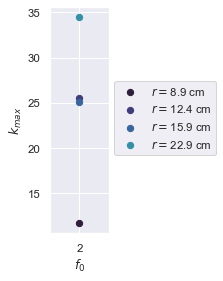

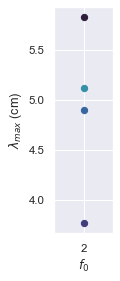

In [6]:
colors = sns.color_palette('mako')
f0 = get_f0(np.array(R_vals))

ri = 0
print(R_vals[ri])
## Plot wavenumber
fig,ax = plt.subplots(figsize=(1,4))
ax.set_xticks([f0[ri]])
for si in range(4):
    ax.scatter(f0[ri], k_max[ri,si],color=colors[si], label=r'$r=$'+f'{radii[si].item()*100:.1f} cm')
ax.legend(bbox_to_anchor=(1,.7))
ax.set_xlabel(r'$f_0$')
ax.set_ylabel(r'$k_{max}$')
plt.show()

## Plot wavelength
fig,ax = plt.subplots(figsize=(1,4))
ax.set_xticks([f0[ri]])
for si in range(4):
    ax.scatter(f0[ri], 100*lambda_max[ri,si],color=colors[si], label=r'$r=$'+f'{radii[si].item()*100:.1f} cm')
# ax.legend()
ax.set_xlabel(r'$f_0$')
ax.set_ylabel(r'$\lambda_{max}$ (cm)')
plt.show()

## second version of the plot

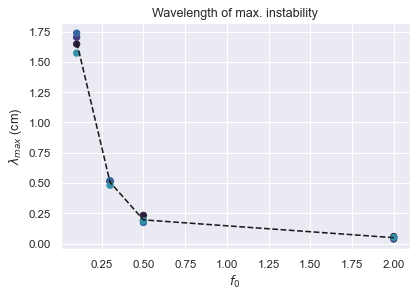

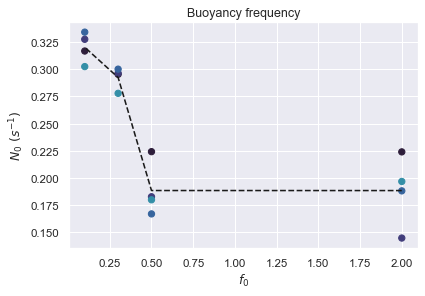

In [7]:
colors = sns.color_palette('mako')
f0 = get_f0(np.array(R_vals))

## Plot wavelength
fig,ax = plt.subplots()
ax.plot(f0, lambda_max.mean(1), c='k', ls='--')
for ri in range(4):
    ax.scatter(np.ones(4)*f0[ri], lambda_max[ri],c=colors[:4])
ax.set_xlabel(r'$f_0$')
ax.set_ylabel(r'$\lambda_{max}$ (cm)')
ax.set_title('Wavelength of max. instability')
plt.show()

## buoyancy plot
fig,ax = plt.subplots()
ax.plot(f0, N0_vals.mean(1), c='k', ls='--')
for ri in range(4):
    ax.scatter(np.ones(4)*f0[ri], N0_vals[ri],c=colors[:4])
ax.set_xlabel(r'$f_0$')
ax.set_ylabel(r'$N_0~(s^{-1})$')
ax.set_title('Buoyancy frequency')
plt.show()

## Compute wavenumber and $L_d$

/home/theo/miniconda3/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/home/theo/miniconda3/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/home/theo/miniconda3/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


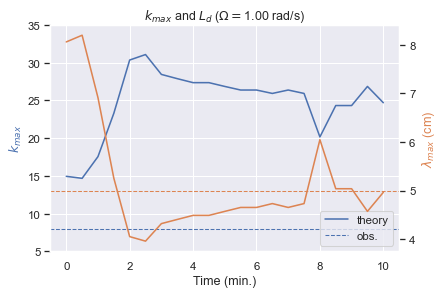

/home/theo/miniconda3/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/home/theo/miniconda3/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/home/theo/miniconda3/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


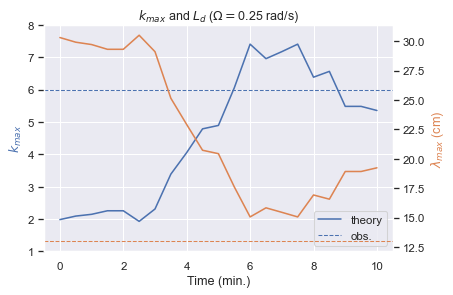

/home/theo/miniconda3/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/home/theo/miniconda3/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/home/theo/miniconda3/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


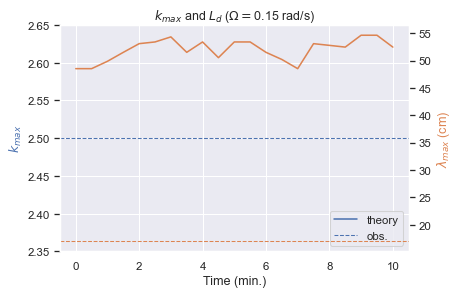

/home/theo/miniconda3/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/home/theo/miniconda3/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/home/theo/miniconda3/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


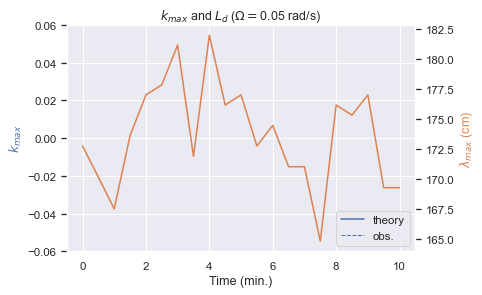

In [8]:
use_l = True # whether to factor in meridional wavenumber
si    = -2    # index of sensor
plot_k = True
plot_Ld= True
alpha = 0.05 # plotting hyper-params 
lw    = 1
k_obss = [8, 6, 2.5, np.nan]
Ld_obss= [5, 13,17,np.nan]

for ri in range(4):

    k_est  = k_obss[ri]
    Ld_est = Ld_obss[ri]

    results = np.stack([np.stack(compute_kappa(r, use_l=use_l),axis=2) for r in R_vals], axis=2)
    kappas, Lds = results[...,0], results[...,1]                  
    colors = sns.color_palette()
    fig,ax = plt.subplots()
    f0 = get_f0(R_vals[ri])
    ax.set_title(r'$k_{max}$ and $L_d$ ($\Omega=$'+f'{f0/2:.2f} rad/s)')

    if plot_k:
        ax.plot(time_min, kappas[:,si,ri], c=colors[0], label='theory')
        ax.axhline(k_est, c=colors[0],ls='--', label='obs.', lw=lw)
        ax.set_ylabel(r'$k_{max}$', c=colors[0])
        ax.set_xlabel('Time (min.)')

    if plot_Ld:
        ax2 = ax.twinx()
        ax2.grid(False)
        ax2.plot(time_min, 3.9*100*Lds[:,si,ri], label='L_d', c=colors[1])
        ax2.axhline(Ld_est, c=colors[1],ls='--', lw=lw)
        ax2.set_ylabel(r'$\lambda_{max}$ (cm)', c=colors[1])
#         ax2.set_ylim([0,6])

    ax.set_yticks(np.linspace(ax.get_yticks()[0], ax.get_yticks()[-1], len(ax.get_yticks())))

    ax.legend(loc='lower right')
    plt.show()